In [1]:
import pandas as pd
from data_clean import DataClean
from add_public_data import PublicData
from create_lag import CreateLag
from cust_seg import CustSeg
from split import Split
from std_scale import StdScale
from pred_model import PredModel
from forcast import Forcast
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import rc
from model_functions import plot_rmse, model_clusters

In [2]:
%matplotlib inline
pd.set_option('max_columns',500)
font = {'size': 20}
rc('font', **font)
plt.style.use('seaborn-dark-palette')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
df = pd.read_pickle('../data/SRP/raw_mini_subset.pkl')

In [ ]:
df_info = df[['address1', 'address2', 'city', 'state', 'postal_code']]

In [ ]:
df_filt = pd.DataFrame()
i = 0
for add in df_info.address1.unique():
    mask = df_info.address1 == add
    for index, row in df_info[ mask ].iterrows():
        df_filt.set_value(i, 'address1', row[0])
        df_filt.set_value(i, 'street', row[1])
        df_filt.set_value(i, 'city', row[2])
        df_filt.set_value(i, 'state', row[3])
        df_filt.set_value(i, 'zip_code', row[4])
        i += 1
        break

In [ ]:
df_filt.to_pickle('../data/SRP/custs_by_address.pkl')

In [ ]:
df_filt.head()

In [4]:
# middle 1
dc = DataClean(remove_nan_rows=True)
df_clean = dc.fit_transform(df)

In [5]:
# middle 2
pub = PublicData(include_crime=False, remove_nan_rows=True)
df_public_cust = pub.fit_transform(df_clean)

In [ ]:
# left 1
cl_cat = CreateLag(lag_periods=2, col_filters=['address1', 'item_category'], 
                   date_col='visit_date', lag_vars=['qty_shrink_per_day', 'shrink_value_per_day'], 
                   col_name_suf='_by_cat', remove_nan_rows=True)
df_lag_cat = cl_cat.fit_transform(df_clean)

In [6]:
# middle 3
cs = CustSeg(clusters=4, plot_clusts=False)
_, cust_table = cs.fit_transform(df_public_cust)

shrink_cust_mask = (cust_table.dtypes == float)
shrink_cust_cols = list(cust_table.columns[ shrink_cust_mask ])

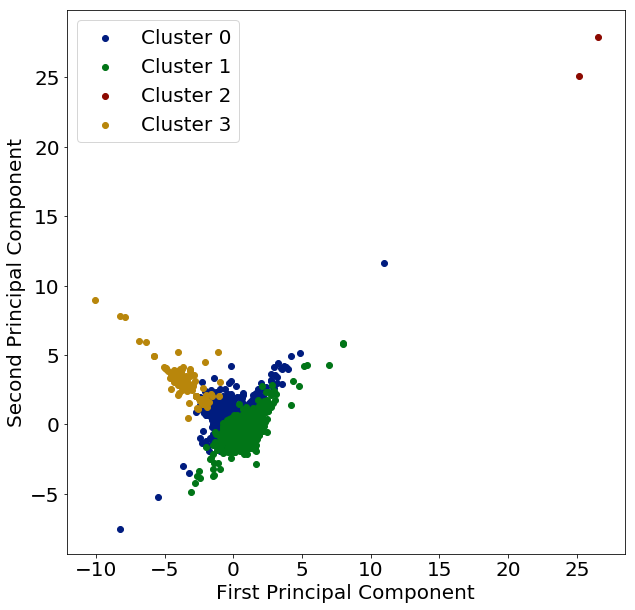

In [12]:
cust_pca = PCA(2)
pca = cust_pca.fit_transform(cust_table[shrink_cust_cols])
colors=['C0', 'C1', 'C2', 'C4']
plt.figure(figsize=(10,10))
for clust in sorted(cust_table.cluster.unique()):
    clust_mask = cust_table.cluster == clust
    plt.scatter(pca[:,0][clust_mask], pca[:,1][clust_mask], label='Cluster {}'.format(clust), color=colors[int(clust)])
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
plt.legend()
#plt.yscale('log')
#plt.savefig('../images/cluster.png')
plt.show()

In [ ]:
f = open("cities.txt","w+")
for cust in cust_table[['street', 'zip_code', 'cluster']].values:
    cust = list(cust)
    clust = cust.pop()
    if clust == '0':
        f.write('{} {} <default-dot>'.format(cust[0], cust[1]))
    elif clust == '1':
        f.write('{} {} <blue-dot>'.format(cust[0], cust[1]))
    elif clust == '2':
        f.write('{} {} <green-dot>'.format(cust[0], cust[1]))
    elif clust == '3':
        f.write('{} {} <violet-dot>'.format(cust[0], cust[1]))
    f.write('\n')
f.close()

In [ ]:
import pandas as pd
import os
from geopy import geocoders
from geopy.geocoders import GoogleV3

API_KEY = os.getenv("API1234")
g = GoogleV3(api_key=API_KEY)

street_i = df_filt.columns.get_loc('state')
city_i = df_filt.columns.get_loc('city')
state_i = df_filt.columns.get_loc('state')
zip_i = df_filt.columns.get_loc('zip_code')

for index, row in df_filt.iterrows():
    street = row[street_i]
    city = row[city_i]
    state = row[state_i]
    zip_code = row[zip_i]
    address = '{} {}, {}, {}'.format(street, city, state, zip_code)
    try:
        loc = g.geocode(address, timeout=15)
        df_filt.set_value(index, 'latitude', loc.latitude)
        df_filt.set_value(index, 'longitude', loc.longitude)
    except Exception as e:
        print('Error, skipping address...', e)

In [ ]:
cust_table[['street', 'zip_code', 'cluster']].values[:60]

In [ ]:
# right 1
cl_store = CreateLag(lag_periods=2, col_filters=['address1'], 
                   date_col='visit_date', lag_vars=['qty_shrink_per_day', 'shrink_value_per_day'], 
                   col_name_suf='_by_store', remove_nan_rows=True)
df_lag_store = cl_store.fit_transform(df_clean)

### Public for Lag

In [ ]:
# left 2
df_public_cat = pub.fit_transform(df_lag_cat)

In [ ]:
# right 2
df_public_store = pub.fit_transform(df_lag_store)

### Split

In [ ]:
non_feature_cols = ['shrink_value', 'shrink_to_sales_value_pct', 'shrink_value_out', 'shrink_to_sales_value_pct_out',
               'shrink_value_ex_del', 'shrink_to_sales_value_pct_ex_del', 'qty_inv_out', 'qty_shrink',
               'qty_shrink_ex_del', 'qty_shrink_out', 'qty_end_inventory', 'qty_f', 'qty_out', 'qty_ex_del',
               'qty_n', 'qty_delivery', 'qty_o', 'qty_d', 'qty_shrink_per_day', 'shrink_value_per_day']

In [ ]:
# left 3
spl_cat = Split(non_feature_cols, target_col='shrink_value_per_day', split_by_time=False)
spl_cat.fit(df_public_cat, cust_table)
X, y, X_train_cat, X_test_cat, y_train_cat, y_test_cat \
= spl_cat.transform(df_public_cat, cust_table)

In [ ]:
# right 3
split_date = pd.to_datetime('12/15/2017')
spl_store = Split(non_feature_cols, target_col='shrink_value_per_day', split_by_time=True, date_col='visit_date', split_date=split_date)
spl_store.fit(df_public_store, cust_table)
X, y, X_train_store, X_test_store, y_train_store, y_test_store \
= spl_store.transform(df_public_store, cust_table)

### Std and Scale

In [ ]:
ss = StdScale(std=True, scale=True)

In [ ]:
# left 4
X_train_cat_ss = ss.fit_transform(X_train_cat)
X_test_cat_ss = ss.fit_transform(X_test_cat)

In [ ]:
# right 4
X_ss = ss.fit_transform(X)
X_train_store_ss = ss.fit_transform(X_train_store)
X_test_store_ss = ss.fit_transform(X_test_store)

### Test Models

In [ ]:
# left 
cluster_rmse, naive_rmse, cluster_models = model_clusters(mlp_list, X_train, X_test, X_test_ns, 'shrink_value_per_day_lag1_by_cat', model_mask_cols, y_train, y_test)
plot_rmse(cluster_rmse, naive_rmse, num_clusters=len(X_train.cluster.unique()), 
          title='Predicting Next Visit Shrink Value')

### Model

In [ ]:
model = MLPRegressor()
params = {'hidden_layer_sizes': [(300,), (100,), (50,50), (50,50,50)], 'learning_rate_init': [0.01, 0.001, 0.0001], 
          'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['adam'],  'max_iter': [200]}
params_basic = {'hidden_layer_sizes': [(10)], 'learning_rate_init': [0.01], 
          'activation': ['relu'], 'solver': ['adam'],  'max_iter': [10]}

In [ ]:
# left 5
pm = PredModel(model, params_basic)
pm.fit(X_train_cat_ss, y_train_cat)

In [ ]:
# left 5 (continued)
preds = pm.predict(X_test_cat_ss)
preds[:10]

In [ ]:
# right 5
forc_cols = ['FD_ratio', 'LAPOP1_10', 'POP2010', 'dens_sq_mile', 'unemp_rate', 'qty_POG_limit', 'unit_price', 
             'shrink_value_per_day_lag1_by_store', 'shrink_value_per_day_lag2_by_store' ]
for col in X_ss.columns:
    if 'customer_id' in col:
        forc_cols.append(col)
fc = Forcast(model, params_basic, forc_cols, num_periods=4)
fc.fit(X_ss, y)

In [ ]:
# right 5 (continued)
forc_cust_table = fc.forcast(cust_table)
forc_cust_table.head()